In [1]:

import tensorflow
import keras

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


0001TP_006690.png
seg.shape=(360, 480, 3), img_is.shape=(360, 480, 3)
The total number of  classes = 12


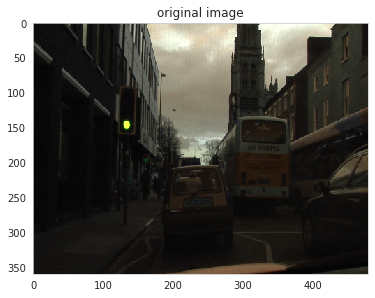

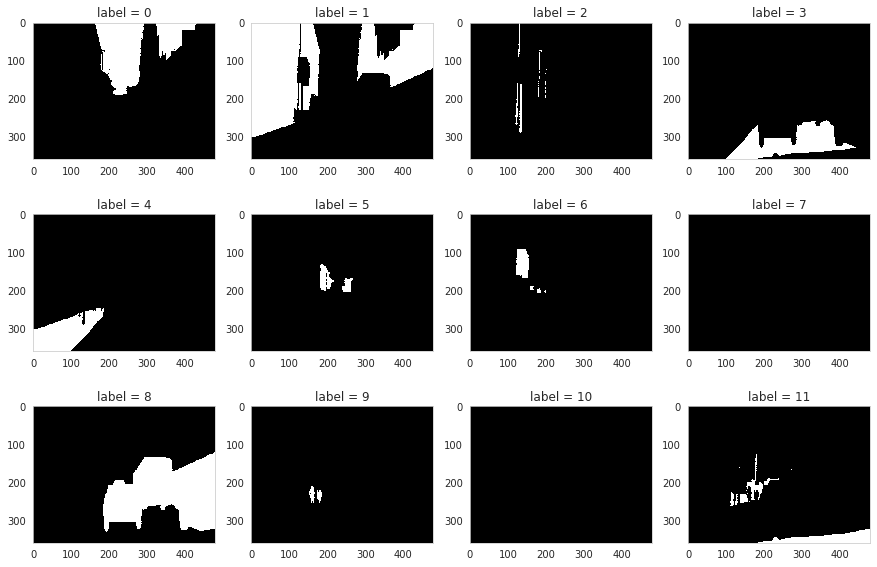

In [6]:
import random

# Path to the training and testing data
dir_data = "/content/drive/My Drive/HCI_prep/dataset1/"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"
dir_seg_test = dir_data + "/annotations_prepped_test/"
dir_img_test = dir_data + "/images_prepped_test/"
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


ldseg = np.array(os.listdir(dir_seg))
## pick the first image from training data
fnm = ldseg[0]
print(fnm)

## read in the original image of training data and segmentation labels of the training data
seg = cv2.imread(dir_seg + fnm ) # (360, 480, 3)
img_is = cv2.imread(dir_img + fnm )

## print number of labels
mi, ma = np.min(seg), np.max(seg)
n_classes = ma - mi + 1
print("The total number of  classes =" , n_classes)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()

fig = plt.figure(figsize=(15,10))
for k in range(mi,ma+1):
    ax = fig.add_subplot(3,n_classes/3,k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))

plt.show()

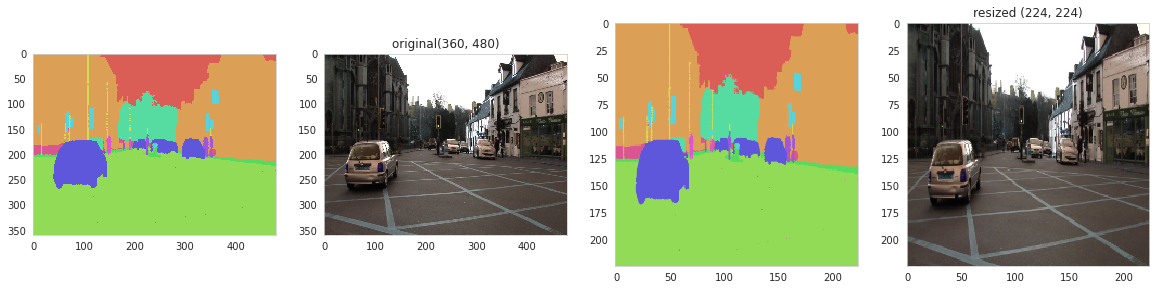

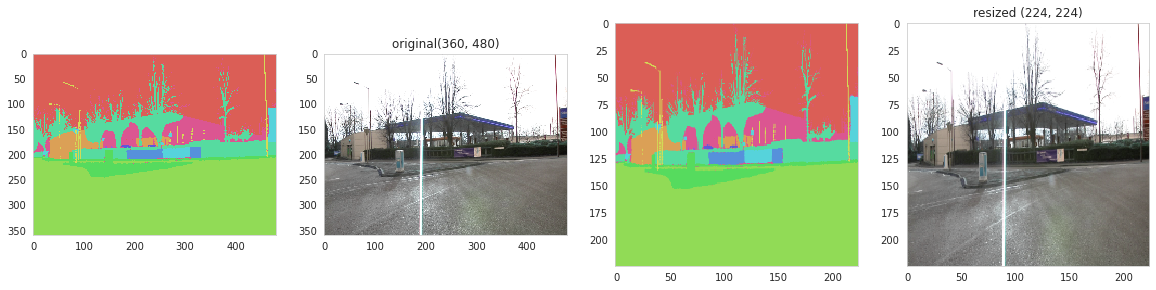

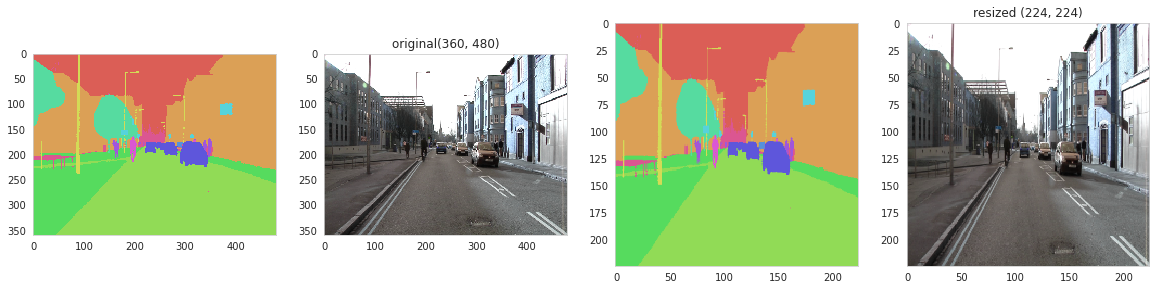

In [15]:
# Color the segmentations 
def color_seg_img(seg, n_classes):
  
    if len(seg.shape) == 3:
        seg = seg[:, :, 0]
    seg_img = np.zeros((seg.shape[0], seg.shape[1], 3)).astype('float')
    colors = sns.color_palette("hls", n_classes)

    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:, :, 0] += (segc * (colors[c][0]))
        seg_img[:, :, 1] += (segc * (colors[c][1]))
        seg_img[:, :, 2] += (segc * (colors[c][2]))

    return (seg_img)


input_height, input_width = 224, 224
output_height, output_width = 224, 224

ldseg = np.array(os.listdir(dir_seg))


for fnm in ldseg[np.random.choice(len(ldseg), 3, replace=False)]:
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg + fnm + ".png")  # (360, 480, 3)
    img_is = cv2.imread(dir_img + fnm + ".png")
    seg_img = color_seg_img(seg, n_classes)

    fig = plt.figure(figsize=(20, 40))
    ax = fig.add_subplot(1, 4, 1)
    ax.imshow(seg_img)

    ax = fig.add_subplot(1, 4, 2)
    ax.imshow(img_is / 255.0)
    ax.set_title("original"+ str(img_is.shape[:2]))

    ax = fig.add_subplot(1, 4, 3)
    ax.imshow(cv2.resize(seg_img, (input_height, input_width)))

    ax = fig.add_subplot(1, 4, 4)
    ax.imshow(cv2.resize(img_is, (output_height, output_width)) / 255.0)
    ax.set_title("resized {}".format((output_height, output_width)))
    plt.show()


In [0]:
!ls

In [22]:
def ImageArr(path, width, height):
    img = cv2.imread(path, 1)
    img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
    return img


def SegmentationArr(path, classes, width, height):
    seg_labels = np.zeros((height, width, classes))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (width, height))
    img = img[:, :, 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c).astype(int)
    return seg_labels


images_train = os.listdir('/content/drive/My Drive/HCI_prep/dataset1/images_prepped_train')
images_train.sort()
segmentations_train = os.listdir('/content/drive/My Drive/HCI_prep/dataset1/annotations_prepped_train')
segmentations_train.sort()


images_test = os.listdir('/content/drive/My Drive/HCI_prep/dataset1/images_prepped_test')
images_test.sort()
segmentations_test = os.listdir('/content/drive/My Drive/HCI_prep/dataset1/annotations_prepped_test')
segmentations_test.sort()


X_train = []
X_test = []

Y_train = []
Y_test = []

for im, seg in zip(images_train, segmentations_train):
    X_train.append(ImageArr(dir_img + im, input_width, input_height))
    Y_train.append(SegmentationArr(dir_seg + seg, n_classes, output_width, output_height))

for im, seg in zip(images_test, segmentations_test):
    X_test.append(ImageArr(dir_img_test + im, input_width, input_height))
    Y_test.append(SegmentationArr(dir_seg_test + seg, n_classes, output_width, output_height))

X_tr, Y_tr = np.array(X_train), np.array(Y_train)
print(X_tr.shape, Y_tr.shape)


X_tst, Y_tst = np.array(X_test), np.array(Y_test)
print(X_tst.shape, Y_tst.shape)



(367, 224, 224, 3) (367, 224, 224, 12)
(101, 224, 224, 3) (101, 224, 224, 12)


In [23]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras, sys, time, warnings
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import pandas as pd

'''
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
config =  tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "2"
'''
set_session(tf.compat.v1.Session())

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))
VGG_Weights_path = "/content/drive/My Drive//HCI_prep/vgg16weights_tf_kernels_notop.h5"


python 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
keras version 2.2.5
tensorflow version 1.15.0


In [0]:
!ls

In [45]:
def FCN8(nClasses, input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height % 32 == 0
    assert input_width % 32 == 0
    IMAGE_ORDERING = "channels_last"

    img_input = Input(shape=(input_height, input_width, 3))  ## Assume 224,224,3

    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING)(
        img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING)(x)
    f1 = x

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING)(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING)(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING)(
        x)  ## (None, 14, 14, 512)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING)(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING)(
        x)  ## (None, 7, 7, 512)

    # x = Flatten(name='flatten')(x)
    # x = Dense(4096, activation='relu', name='fc1')(x)
    # <--> o = ( Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data

    # x = Dense(4096, activation='relu', name='fc2')(x)
    # <--> o = ( Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data

    # x = Dense(1000 , activation='softmax', name='predictions')(x)
    # <--> o = ( Conv2D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data

    vgg = Model(img_input, pool5)
    vgg.load_weights(VGG_Weights_path)  ## loading VGG weights for the encoder parts of FCN8

    n = 4096
    o = (Conv2D(n, (7, 7), activation='relu', padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = (Conv2D(n, (1, 1), activation='relu', padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)

    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose(nClasses, kernel_size=(4, 4), strides=(4, 4), use_bias=False, data_format=IMAGE_ORDERING)(
        conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = (
        Conv2D(nClasses, (1, 1), activation='relu', padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (
        Conv2DTranspose(nClasses, kernel_size=(2, 2), strides=(2, 2), use_bias=False, data_format=IMAGE_ORDERING))(
        pool411)

    pool311 = (
        Conv2D(nClasses, (1, 1), activation='relu', padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)

    o = Add(name="add")([pool411_2, pool311, conv7_4])
    o = Conv2DTranspose(nClasses, kernel_size=(8, 8), strides=(8, 8), use_bias=False, data_format=IMAGE_ORDERING)(o)
    o = (Activation('softmax'))(o)

    model = Model(img_input, o)

    return model


model = FCN8(nClasses=n_classes,
             input_height=224,
             input_width=224)
model.summary()



Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [0]:
from keras import optimizers

sgd = optimizers.SGD(lr=1E-2, momentum=0.91,decay=5**(-4), nesterov=True)

model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'],)


hist1 = model.fit(X_tr,Y_tr,validation_data=(X_tst,Y_tst),batch_size=32,epochs=300,verbose=2)

model.save("/content/drive/My Drive/HCI_prep/fcn_8_model.h5")

Train on 367 samples, validate on 101 samples
Epoch 1/300
367/367 - 8s - loss: 1.7131 - acc: 0.4440 - val_loss: 1.7667 - val_acc: 0.4000
Epoch 2/300
367/367 - 8s - loss: 1.6231 - acc: 0.4633 - val_loss: 1.7126 - val_acc: 0.4199
Epoch 3/300
367/367 - 8s - loss: 1.5673 - acc: 0.4860 - val_loss: 1.6765 - val_acc: 0.4310
Epoch 4/300
367/367 - 8s - loss: 1.5276 - acc: 0.4980 - val_loss: 1.6462 - val_acc: 0.4332
Epoch 5/300
367/367 - 8s - loss: 1.4958 - acc: 0.5018 - val_loss: 1.6197 - val_acc: 0.4341
Epoch 6/300
367/367 - 8s - loss: 1.4697 - acc: 0.5043 - val_loss: 1.6040 - val_acc: 0.4361
Epoch 7/300
367/367 - 8s - loss: 1.4481 - acc: 0.5070 - val_loss: 1.5852 - val_acc: 0.4380
Epoch 8/300
367/367 - 8s - loss: 1.4307 - acc: 0.5110 - val_loss: 1.5702 - val_acc: 0.4373
Epoch 9/300
367/367 - 8s - loss: 1.4166 - acc: 0.5131 - val_loss: 1.5477 - val_acc: 0.4357
Epoch 10/300
367/367 - 8s - loss: 1.4056 - acc: 0.5136 - val_loss: 1.5370 - val_acc: 0.4343
Epoch 11/300
367/367 - 8s - loss: 1.3955 - 

In [0]:
for key in ['acc', 'val_acc']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy(*100%)")
plt.title("Training and Validation Accuracy")
plt.savefig('niloy_jeepi_acc.png')
plt.show()

In [0]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.savefig('niloy_jeepi_loss.png')

plt.show()

In [0]:
for key in ['loss', 'val_loss','acc', 'val_acc']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("plot for FCN-8")
plt.savefig('niloy.png', dpi= 150)

plt.show()

[1.0455321866095229, 0.5266089462129556, 0.36686032336479313, 0.27701692132923844, 0.2343003596369512]
[0.8172276297418197, 0.6837929475425494, 0.6718177340998508, 0.7437124724435334, 0.7611483813512443]


Text(0, 0.5, 'Accuracy')

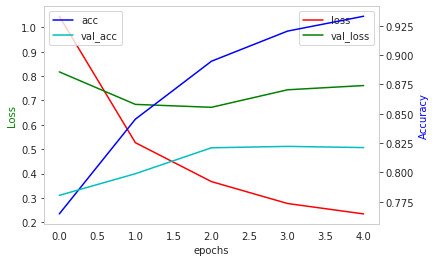

In [37]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
c=0
col= ["r","g","b","c"]
for key1 in ['loss', 'val_loss']:
    print(hist1.history[key1])
    ax1.plot(hist1.history[key1],label=key1, c=col[c])
    ax1.legend()
    c=c+1
for key2 in ['acc', 'val_acc']:
    ax2.plot(hist1.history[key2],label=key2, c=col[c])
    ax2.legend()
    c=c+1


ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Accuracy', color='b')
plt.savefig("/content/drive/My Drive//HCI_prep/loss_acc_fcn_8")